ML Project: Matrix Completion v3
------
1. load libraries and data (both movielens and netflix datasets)
2. preprocess both datasets - prepare for training, test, validation
    - this includes breaking down the fields, converting user-item
    interaction data into CSR sparse matrices, split into training, val, test, create data loaders
3. define autoencoder architecture + include appropriate regularization (define two cost functions)
4. train model (with regularized costf), monitor loss over epochs + validation loss over epochs
5. k fold validation to tune hyperparameters, test model performance - find best regularization parameter
6. train the model once more with the optimal regularization parameter
7. visualize results: for a given userID, output users best rated movies + generated recommendations based on trained model, compare actual vs predicted ratings for users (ground truth)



In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Function to load Netflix movie titles
def read_netflix_titles(file_path):
    movie_ids = []
    years = []
    titles = []
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            parts = line.strip().split(',', 2)
            movie_id = int(parts[0])
            year = parts[1]
            title = parts[2]
            try:
                year = int(year)
            except ValueError:
                year = None
            movie_ids.append(movie_id)
            years.append(year)
            titles.append(title)
    return pd.DataFrame({'movieId': movie_ids, 'year': years, 'title': titles})

netflix_titles = read_netflix_titles('netflix/movie_titles.txt')

# Function to load reviews from Netflix dataset
def load_netflix_reviews(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    reviews = []
    movie_id = None
    for line in lines:
        if ':' in line:
            movie_id = int(line.split(':')[0])
        else:
            user_id, rating, _ = line.split(',')
            reviews.append((int(user_id), movie_id, float(rating)))
    return reviews

# Load all reviews
import os
netflix_reviews = []
directory = 'netflix'
for filename in os.listdir(directory):
    if filename.startswith('mv_'):
        file_path = os.path.join(directory, filename)
        netflix_reviews.extend(load_netflix_reviews(file_path))

netflix_ratings_data = pd.DataFrame(netflix_reviews, columns=['userId', 'movieId', 'rating'])



# Print basic info about the datasets
print("Netflix Ratings Data:")
print(netflix_ratings_data.head())

print("Netflix Titles Data:")
print(netflix_titles.head())




Netflix Ratings Data:
    userId  movieId  rating
0  1488844        1     3.0
1   822109        1     5.0
2   885013        1     4.0
3    30878        1     4.0
4   823519        1     3.0
Netflix Titles Data:
   movieId    year                         title
0        1  2003.0               Dinosaur Planet
1        2  2004.0    Isle of Man TT 2004 Review
2        3  1997.0                     Character
3        4  1994.0  Paula Abdul's Get Up & Dance
4        5  2004.0      The Rise and Fall of ECW


breaking down the fields and plotting the normalized rating distributions

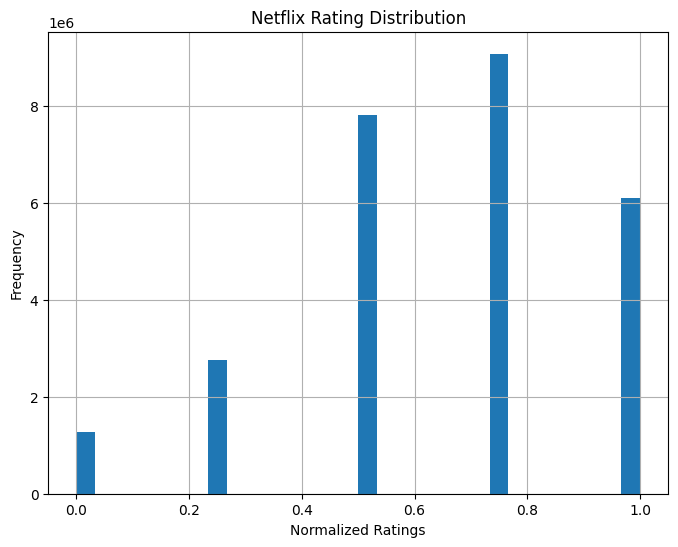

In [46]:
import matplotlib.pyplot as plt

# Normalize ratings
def normalize_ratings(ratings):
    min_rating = ratings.min()
    max_rating = ratings.max()
    return (ratings - min_rating) / (max_rating - min_rating), min_rating, max_rating

# Normalize Netflix ratings
netflix_ratings_data['rating'], netflix_min_rating, netflix_max_rating = normalize_ratings(netflix_ratings_data['rating'])


# Plot rating distributions
def plot_rating_distribution(ratings, title):
    plt.figure(figsize=(8, 6))
    ratings.hist(bins=30)
    plt.title(title)
    plt.xlabel('Normalized Ratings')
    plt.ylabel('Frequency')
    plt.show()

# Plot the distribution of Netflix ratings
plot_rating_distribution(netflix_ratings_data['rating'], 'Netflix Rating Distribution')




show the reviews made by a user, say userID 100 

In [47]:
def get_user_reviews(user_id, ratings_data, titles_data):
    user_reviews = ratings_data[ratings_data['userId'] == user_id]
    reviews_with_titles = user_reviews.merge(titles_data, on='movieId')
    return reviews_with_titles

# Display reviews for userID 100 in Netflix dataset
netflix_user_id = 1488844
netflix_user_reviews = get_user_reviews(netflix_user_id, netflix_ratings_data, netflix_titles)

print(f"Netflix Reviews for User ID {netflix_user_id}:")
for _, row in netflix_user_reviews.iterrows():
    print(f"{row['title']}: Rating: {row['rating'] * (netflix_max_rating - netflix_min_rating) + netflix_min_rating:.2f}")



Netflix Reviews for User ID 1488844:
Dinosaur Planet: Rating: 3.00
What the #$*! Do We Know!?: Rating: 4.00
7 Seconds: Rating: 2.00
Something's Gotta Give: Rating: 3.00
Spitfire Grill: Rating: 3.00
Dragonheart: Rating: 5.00
I Love Lucy: Season 2: Rating: 3.00
Winter Kills: Rating: 3.00
Antarctica: IMAX: Rating: 3.00
Silkwood: Rating: 3.00
Spartan: Rating: 3.00
Duplex (Widescreen): Rating: 2.00
Rambo: First Blood Part II: Rating: 3.00
The Game: Rating: 5.00
The Devil's Brigade: Rating: 3.00
Reservoir Dogs: Rating: 3.00
Death to Smoochy: Rating: 2.00
Airplane II: The Sequel: Rating: 2.00
X2: X-Men United: Rating: 5.00
Chasing Freedom: Rating: 4.00
Taking Lives: Rating: 3.00
The Deer Hunter: Rating: 3.00
Impostor: Rating: 3.00
Gross Anatomy: Rating: 3.00
North by Northwest: Rating: 3.00
The Final Countdown: Rating: 4.00
Sex and the City: Season 4: Rating: 4.00
Taxi: Rating: 2.00
Evelyn: Rating: 3.00
The Devil's Own: Rating: 4.00
Bridget Jones's Diary: Rating: 3.00
Jack: Rating: 3.00
High 

create CSR sparse user-item matrices

In [48]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Function to create user-item and mask matrices
def create_matrices(ratings_data):
    # Factorize user and movie IDs
    user_id_mapping, user_unique_ids = pd.factorize(ratings_data['userId'])
    movie_id_mapping, movie_unique_ids = pd.factorize(ratings_data['movieId'])

    # Create DataFrame to map factorized IDs back to original IDs
    user_id_map_df = pd.DataFrame({'original_user_id': user_unique_ids, 'factorized_user_id': range(len(user_unique_ids))})
    movie_id_map_df = pd.DataFrame({'original_movie_id': movie_unique_ids, 'factorized_movie_id': range(len(movie_unique_ids))})

    # Replace the original IDs with the factorized IDs
    ratings_data['userId'] = user_id_mapping
    ratings_data['movieId'] = movie_id_mapping

    # Get max user and movie IDs
    max_user_id = user_id_mapping.max() + 1
    max_movie_id = movie_id_mapping.max() + 1

    # Normalize ratings
    min_rating = ratings_data['rating'].min()
    max_rating = ratings_data['rating'].max()
    ratings_data['rating'] = (ratings_data['rating'] - min_rating) / (max_rating - min_rating)

    # Create the user-item matrix and the mask matrix
    data = ratings_data['rating'].values
    rows = ratings_data['userId'].values
    cols = ratings_data['movieId'].values

    user_item_matrix = csr_matrix((data, (rows, cols)), shape=(max_user_id, max_movie_id))
    genuine_ratings_mask = csr_matrix((np.ones_like(data), (rows, cols)), shape=(max_user_id, max_movie_id))

    return user_item_matrix, genuine_ratings_mask, user_id_map_df, movie_id_map_df, min_rating, max_rating

# Create matrices for Netflix dataset
netflix_user_item_matrix, netflix_genuine_ratings_mask, netflix_user_id_map_df, netflix_movie_id_map_df, netflix_min_rating, netflix_max_rating = create_matrices(netflix_ratings_data)

# Print matrix info
def print_matrix_info(matrix, name):
    shape = matrix.shape
    nnz = matrix.nnz
    sparsity = 1 - nnz / (shape[0] * shape[1])
    print(f"{name} Matrix Info:")
    print(f"Shape: {shape}")
    print(f"Non-zero entries: {nnz}")
    print(f"Sparsity: {sparsity:.4f}")
    print()

print_matrix_info(netflix_user_item_matrix, "Netflix User-Item")
print_matrix_info(netflix_genuine_ratings_mask, "Netflix Mask")

# Helper functions to map factorized IDs back to original IDs
def factorized_to_original_user_id(factorized_id, user_id_map_df):
    return user_id_map_df.loc[user_id_map_df['factorized_user_id'] == factorized_id, 'original_user_id'].values[0]

def factorized_to_original_movie_id(factorized_id, movie_id_map_df):
    return movie_id_map_df.loc[movie_id_map_df['factorized_movie_id'] == factorized_id, 'original_movie_id'].values[0]

def original_to_factorized_user_id(original_id, user_id_map_df):
    if original_id in user_id_map_df['original_user_id'].values:
        return user_id_map_df.loc[user_id_map_df['original_user_id'] == original_id, 'factorized_user_id'].values[0]
    else:
        print(f"Original user ID {original_id} not found.")
        return None

def original_to_factorized_movie_id(original_id, movie_id_map_df):
    if original_id in movie_id_map_df['original_movie_id'].values:
        return movie_id_map_df.loc[movie_id_map_df['original_movie_id'] == original_id, 'factorized_movie_id'].values[0]
    else:
        print(f"Original movie ID {original_id} not found.")
        return None

# Example: Get reviews for a specific user (factorized and original IDs)
specific_user_id = 1488844
factorized_user_id = original_to_factorized_user_id(specific_user_id, netflix_user_id_map_df)

if factorized_user_id is not None:
    # Extract user's reviews from the user-item matrix
    user_ratings = netflix_user_item_matrix.getrow(factorized_user_id).toarray().flatten()
    rated_movie_indices = np.where(user_ratings > 0)[0]
    ratings = user_ratings[rated_movie_indices]

    # Map factorized movie IDs back to original IDs
    original_movie_ids = [factorized_to_original_movie_id(movie_id, netflix_movie_id_map_df) for movie_id in rated_movie_indices]

    # Get movie titles using the original movie IDs
    movie_titles = netflix_titles[netflix_titles['movieId'].isin(original_movie_ids)]

    # Print the results
    print(f"Reviews for user {specific_user_id} (Factorized ID: {factorized_user_id}):")
    for original_movie_id, rating in zip(original_movie_ids, ratings):
        movie_title = movie_titles[movie_titles['movieId'] == original_movie_id]['title'].values[0]
        print(f"Movie: {movie_title}, Original Movie ID: {original_movie_id}, Rating: {rating * (netflix_max_rating - netflix_min_rating) + netflix_min_rating}")
else:
    print(f"Factorized user ID for {specific_user_id} not found.")


Netflix User-Item Matrix Info:
Shape: (472556, 5007)
Non-zero entries: 27029667
Sparsity: 0.9886

Netflix Mask Matrix Info:
Shape: (472556, 5007)
Non-zero entries: 27029667
Sparsity: 0.9886

Reviews for user 1488844 (Factorized ID: 0):
Movie: Dinosaur Planet, Original Movie ID: 1, Rating: 0.5
Movie: What the #$*! Do We Know!?, Original Movie ID: 8, Rating: 0.75
Movie: 7 Seconds, Original Movie ID: 17, Rating: 0.25
Movie: Something's Gotta Give, Original Movie ID: 30, Rating: 0.5
Movie: Spitfire Grill, Original Movie ID: 44, Rating: 0.5
Movie: Dragonheart, Original Movie ID: 58, Rating: 1.0
Movie: I Love Lucy: Season 2, Original Movie ID: 76, Rating: 0.5
Movie: Winter Kills, Original Movie ID: 80, Rating: 0.5
Movie: Antarctica: IMAX, Original Movie ID: 81, Rating: 0.5
Movie: Silkwood, Original Movie ID: 83, Rating: 0.5
Movie: Spartan, Original Movie ID: 108, Rating: 0.5
Movie: Duplex (Widescreen), Original Movie ID: 111, Rating: 0.25
Movie: Rambo: First Blood Part II, Original Movie ID:

split the data into training, validation, test + create pytorch datasets and create dataloaders

In [49]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

# Split the data
netflix_train_indices, netflix_test_indices = train_test_split(np.arange(netflix_user_item_matrix.shape[0]), test_size=0.2, random_state=42)
netflix_train_indices, netflix_val_indices = train_test_split(netflix_train_indices, test_size=0.25, random_state=42)

print(f"Is factorized user ID {factorized_user_id} in training indices? {'Yes' if factorized_user_id in netflix_train_indices else 'No'}")
print(f"Is factorized user ID {factorized_user_id} in validation indices? {'Yes' if factorized_user_id in netflix_val_indices else 'No'}")
print(f"Is factorized user ID {factorized_user_id} in test indices? {'Yes' if factorized_user_id in netflix_test_indices else 'No'}")

# Create datasets
class CSRDataset(Dataset):
    def __init__(self, user_item_matrix, mask_matrix, indices):
        self.user_item_matrix = user_item_matrix
        self.mask_matrix = mask_matrix
        self.indices = indices
        print(f"Dataset initialized with {len(self.indices)} users.")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_idx = self.indices[idx]
        dense_row = self.user_item_matrix[user_idx].toarray().squeeze(0)
        mask_row = self.mask_matrix[user_idx].toarray().squeeze(0)
        dense_tensor = torch.from_numpy(dense_row).float()
        mask_tensor = torch.from_numpy(mask_row).float()
        return dense_tensor, mask_tensor

netflix_train_dataset = CSRDataset(netflix_user_item_matrix, netflix_genuine_ratings_mask, netflix_train_indices)
netflix_val_dataset = CSRDataset(netflix_user_item_matrix, netflix_genuine_ratings_mask, netflix_val_indices)
netflix_test_dataset = CSRDataset(netflix_user_item_matrix, netflix_genuine_ratings_mask, netflix_test_indices)

# Function to extract ratings and corresponding mask values for a user
def get_user_data(dataset, user_id):
    for idx in range(len(dataset)):
        user_idx = dataset.indices[idx]
        if user_idx == user_id:
            dense_tensor, mask_tensor = dataset[idx]
            user_ratings = dense_tensor.numpy()
            user_mask = mask_tensor.numpy()
            return user_ratings, user_mask
    return None, None

# Get the data for the specific user
user_ratings, user_mask = get_user_data(netflix_val_dataset, factorized_user_id)

if user_ratings is not None and user_mask is not None:
    # Filter out the indices where the mask is non-zero
    mask_non_zero_indices = np.nonzero(user_mask)[0]
    mask_non_zero_ratings = user_ratings[mask_non_zero_indices]
    mask_non_zero_mask = user_mask[mask_non_zero_indices]

    # Print results
    print(f"Indices with non-zero mask values: {mask_non_zero_indices}")
    print(f"Ratings at these indices: {mask_non_zero_ratings}")
    print(f"Mask values at these indices: {mask_non_zero_mask}")
else:
    print(f"User {factorized_user_id} not found in the validation dataset.")


Is factorized user ID 0 in training indices? Yes
Is factorized user ID 0 in validation indices? No
Is factorized user ID 0 in test indices? No
Dataset initialized with 283533 users.
Dataset initialized with 94511 users.
Dataset initialized with 94512 users.
User 0 not found in the validation dataset.


In [27]:
print(f"User-item matrix shape: {netflix_user_item_matrix.shape}")
print(f"User-item matrix non-zero count: {netflix_user_item_matrix.nnz}")
print(f"Mask matrix shape: {netflix_genuine_ratings_mask.shape}")
print(f"Mask matrix non-zero count: {netflix_genuine_ratings_mask.nnz}")

# Check specific entries
print(netflix_user_item_matrix[:5, :5].toarray())
print(netflix_genuine_ratings_mask[:5, :5].toarray())

User-item matrix shape: (472556, 5007)
User-item matrix non-zero count: 27029667
Mask matrix shape: (472556, 5007)
Mask matrix non-zero count: 27029667
[[0.5  0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.75 0.   0.   0.   1.  ]
 [0.75 0.   0.   0.   0.  ]
 [0.5  0.   0.   0.   0.  ]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


defining the two cost functions

In [18]:
from torch import nn

def custom_loss_function(output, target, model, regularization_strength, use_mse=True):
    """
    Custom loss function for training that includes regularization.
    :param output: The predicted output from the model.
    :param target: The ground truth target values.
    :param model: The model whose parameters are being regularized.
    :param regularization_strength: The strength of the L2 regularization.
    :param use_mse: Whether to use MSE loss. If False, MAE loss will be used.
    :return: The calculated loss value.
    """
    if use_mse:
        reconstruction_loss = nn.MSELoss()(output, target)
    else:
        reconstruction_loss = nn.L1Loss()(output, target)

    l2_penalty = sum(p.pow(2.0).sum() for p in model.parameters())
    loss_with_regularization = reconstruction_loss + regularization_strength * l2_penalty

    return loss_with_regularization

def simple_loss_function(output, target, use_mse=True):
    """
    Simple loss function for validation that does not include regularization.
    :param output: The predicted output from the model.
    :param target: The ground truth target values.
    :param use_mse: Whether to use MSE loss. If False, MAE loss will be used.
    :return: The calculated loss value.
    """
    if use_mse:
        loss = nn.MSELoss()(output, target)
    else:
        loss = nn.L1Loss()(output, target)
    return loss


MovieLens Train Loader - First batch info:
Batch shape: torch.Size([128, 5007])
Batch type: torch.float32
Mask shape: torch.Size([128, 5007])
Mask type: torch.float32
Number of samples in batch: 128
MovieLens Validation Loader - First batch info:
Batch shape: torch.Size([128, 5007])
Batch type: torch.float32
Mask shape: torch.Size([128, 5007])
Mask type: torch.float32
Number of samples in batch: 128
MovieLens Test Loader - First batch info:
Batch shape: torch.Size([128, 5007])
Batch type: torch.float32
Mask shape: torch.Size([128, 5007])
Mask type: torch.float32
Number of samples in batch: 128


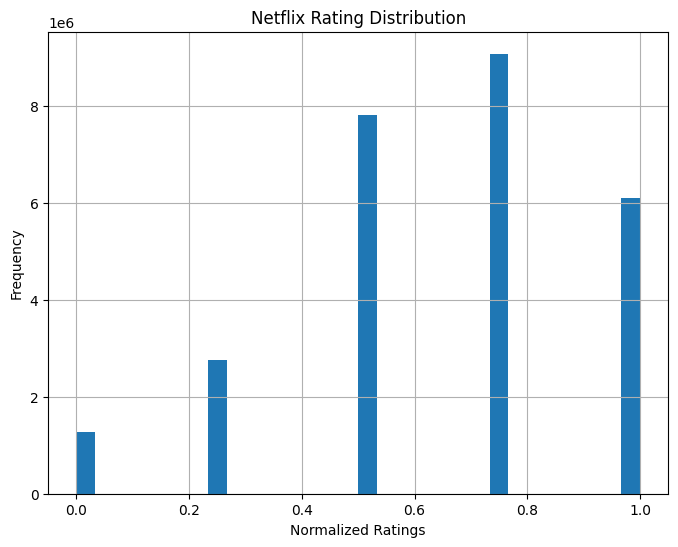

In [29]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Dataloaders
batch_size = 128
train_loader = DataLoader(netflix_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(netflix_val_dataset, batch_size=batch_size)
test_loader = DataLoader(netflix_test_dataset, batch_size=batch_size)

# Print loader info
def print_loader_info(loader, name):
    for i, (data, mask) in enumerate(loader):
        if i == 0:
            print(f"{name} - First batch info:")
            print(f"Batch shape: {data.shape}")
            print(f"Batch type: {data.dtype}")
            print(f"Mask shape: {mask.shape}")
            print(f"Mask type: {mask.dtype}")
            print(f"Number of samples in batch: {data.size(0)}")
            break

print_loader_info(train_loader, "MovieLens Train Loader")
print_loader_info(val_loader, "MovieLens Validation Loader")
print_loader_info(test_loader, "MovieLens Test Loader")

# Plot the distribution of the data
plt.figure(figsize=(8, 6))
netflix_ratings_data['rating'].hist(bins=30)
plt.title('Netflix Rating Distribution')
plt.xlabel('Normalized Ratings')
plt.ylabel('Frequency')
plt.show()


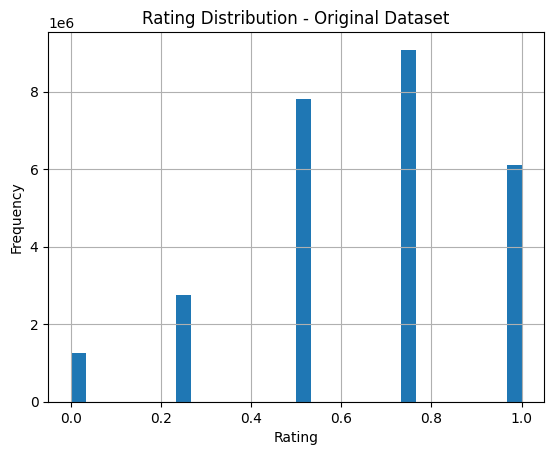

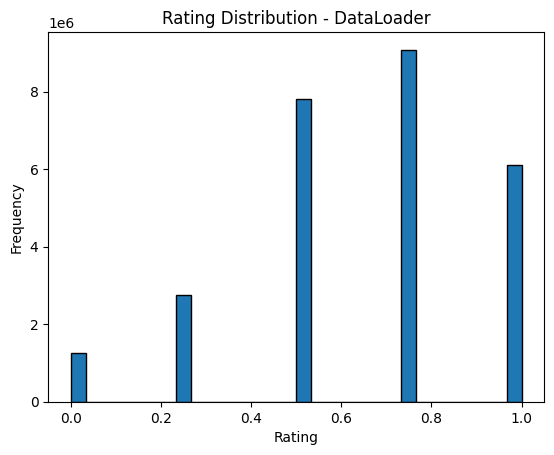

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Plot the rating distribution from the original dataset
netflix_ratings_data['rating'].hist(bins=30)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution - Original Dataset')
plt.show()

# Function to extract all ratings from the DataLoader
def extract_all_ratings_from_loader(loader):
    all_ratings = []
    for data, mask in loader:
        ratings = data[mask.bool()].numpy()  # Extract ratings where mask is 1
        all_ratings.extend(ratings)
    return np.array(all_ratings)

# Step 2: Extract ratings from all loaders
train_ratings = extract_all_ratings_from_loader(train_loader)
val_ratings = extract_all_ratings_from_loader(val_loader)
test_ratings = extract_all_ratings_from_loader(test_loader)

# Combine all ratings
all_ratings = np.concatenate([train_ratings, val_ratings, test_ratings])

# Denormalize ratings
all_ratings = all_ratings * (netflix_max_rating - netflix_min_rating) + netflix_min_rating

# Plot the rating distribution from the DataLoader
plt.hist(all_ratings, bins=30, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution - DataLoader')
plt.show()


stacked autoencoder architecture

In [52]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        encoder_layers = []
        previous_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))  # Batch normalization
            encoder_layers.append(nn.ReLU())
            previous_dim = hidden_dim
        encoder_layers.append(nn.Linear(previous_dim, latent_dim))  # Latent space layer
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        previous_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            decoder_layers.append(nn.BatchNorm1d(hidden_dim))  # Batch normalization
            decoder_layers.append(nn.ReLU())
            previous_dim = hidden_dim
        decoder_layers.append(nn.Linear(previous_dim, input_dim))  # Output layer
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

                         

In [35]:
# Example usage
input_dim = netflix_user_item_matrix.shape[1]  
hidden_dims = [512, 256]  # Adjusted hidden layer sizes
latent_dim = 128

model = EnhancedAutoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Set to CPU
device = torch.device('cpu')
model = model.to(device)

learning_rate = 0.001
batch_size = 64

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Example Dataloaders
train_loader = DataLoader(netflix_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(netflix_val_dataset, batch_size=batch_size)
test_loader = DataLoader(netflix_test_dataset, batch_size=batch_size)



In [36]:

def masked_mse_loss(output, target, mask):
    loss = ((output - target) ** 2) * mask
    return loss.sum() / mask.sum()

In [37]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler, device):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, genuine_mask) in enumerate(train_loader):
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, data, genuine_mask)  # Use the custom masked MSE loss
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Adjust the learning rate
        scheduler.step()

        # Calculate average training loss for the epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, genuine_mask in val_loader:
                data = data.to(device)
                genuine_mask = genuine_mask.to(device)

                output = model(data)
                loss = criterion(output, data, genuine_mask)  # Use the custom masked MSE loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses


In [38]:
# Example usage
input_dim = netflix_user_item_matrix.shape[1]   # Adjust this to match your data
hidden_dims = [512, 256]
latent_dim = 128
model = EnhancedAutoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)
learning_rate = 0.001
batch_size = 64

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
num_epochs = 15
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, masked_mse_loss, optimizer, scheduler, device)


Epoch [1/15], Batch [100/4431], Loss: 0.0829
Epoch [1/15], Batch [200/4431], Loss: 0.0747
Epoch [1/15], Batch [300/4431], Loss: 0.1205
Epoch [1/15], Batch [400/4431], Loss: 0.0608
Epoch [1/15], Batch [500/4431], Loss: 0.0709
Epoch [1/15], Batch [600/4431], Loss: 0.0619
Epoch [1/15], Batch [700/4431], Loss: 0.0691
Epoch [1/15], Batch [800/4431], Loss: 0.0535
Epoch [1/15], Batch [900/4431], Loss: 0.0626
Epoch [1/15], Batch [1000/4431], Loss: 0.0604
Epoch [1/15], Batch [1100/4431], Loss: 0.0727
Epoch [1/15], Batch [1200/4431], Loss: 0.0620
Epoch [1/15], Batch [1300/4431], Loss: 0.0596
Epoch [1/15], Batch [1400/4431], Loss: 0.0581
Epoch [1/15], Batch [1500/4431], Loss: 0.0666
Epoch [1/15], Batch [1600/4431], Loss: 0.0594
Epoch [1/15], Batch [1700/4431], Loss: 0.0661
Epoch [1/15], Batch [1800/4431], Loss: 0.0633
Epoch [1/15], Batch [1900/4431], Loss: 0.0557
Epoch [1/15], Batch [2000/4431], Loss: 0.0582
Epoch [1/15], Batch [2100/4431], Loss: 0.0619
Epoch [1/15], Batch [2200/4431], Loss: 0.05

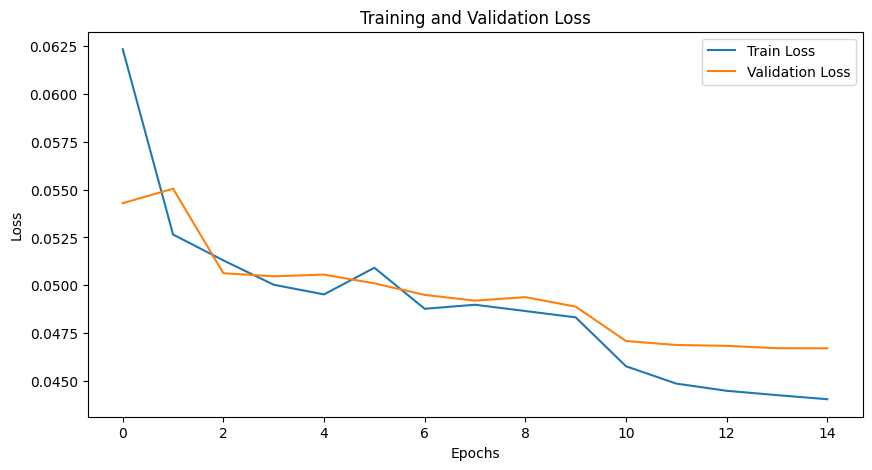

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [42]:

# Save the trained model
torch.save(model.state_dict(), 'netflix_autoencoder.pth')

# Load the model
#loaded_model = EnhancedAutoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)
#loaded_model.load_state_dict(torch.load('netflix_autoencoder.pth'))
#loaded_model.eval()

In [51]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to compare predicted and actual ratings for a specific user in the Netflix dataset
def compare_user_ratings_normalized_netflix(user_id, model, device, user_id_map_df, movie_id_map_df, netflix_titles):
    model.eval()
    with torch.no_grad():
        user_idx = original_to_factorized_user_id(user_id, user_id_map_df)
        if user_idx is not None:
            user_data = netflix_user_item_matrix.getrow(user_idx).toarray().flatten()
            user_mask = netflix_genuine_ratings_mask.getrow(user_idx).toarray().flatten()
            user_tensor = torch.from_numpy(user_data).float().to(device).unsqueeze(0)
            user_mask_tensor = torch.from_numpy(user_mask).float().to(device).unsqueeze(0)

            user_output = model(user_tensor).cpu().numpy().flatten()
            user_ratings = user_tensor.cpu().numpy().flatten()

            # Filter only the movies that the user has rated
            reviewed_indices = np.where(user_mask > 0)[0]
            original_ratings = user_ratings[reviewed_indices]
            predicted_ratings = user_output[reviewed_indices]

            df = pd.DataFrame({
                'MovieID': reviewed_indices,
                'OriginalRating': original_ratings,
                'PredictedRating': predicted_ratings
            })

            # Map factorized movie IDs back to original IDs
            df['MovieID'] = df['MovieID'].apply(lambda x: factorized_to_original_movie_id(x, movie_id_map_df))

            # Add movie titles
            df = df.merge(netflix_titles, left_on='MovieID', right_on='movieId')[['title', 'OriginalRating', 'PredictedRating']]

            # Print the comparison
            print(df)

            # Plot the comparison
            plt.figure(figsize=(10, 5))
            plt.scatter(df['OriginalRating'], df['PredictedRating'], color='blue', label='Data points')
            plt.plot([df['OriginalRating'].min(), df['OriginalRating'].max()],
                     [df['OriginalRating'].min(), df['OriginalRating'].max()], 'r--', label='Ideal line')
            plt.xlabel('Original Ratings (Normalized)')
            plt.ylabel('Predicted Ratings (Normalized)')
            plt.title(f'Original vs Predicted Ratings (Normalized) for User {user_id}')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"User ID {user_id} not found.")
#user_id_map_df = pd.DataFrame({'original_user_id': user_unique_ids, 'factorized_user_id': range(len(user_unique_ids))})
#movie_id_map_df = pd.DataFrame({'original_movie_id': movie_unique_ids, 'factorized_movie_id': range(len(movie_unique_ids))})
# Compare predicted and actual ratings for the specific user with normalized values























compare_user_ratings_normalized_netflix(12, model, device, user_id_map_df, movie_id_map_df, netflix_titles)


NameError: name 'user_id_map_df' is not defined

old code from here onwards

In [ ]:
# Example usage
input_dim = netflix_user_item_matrix.shape[1]  
hidden_dims = [512, 256]  # Adjusted hidden layer sizes
latent_dim = 128

model = EnhancedAutoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Set to CPU
device = torch.device('cpu')
model = model.to(device)

learning_rate = 0.001
batch_size = 64

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Example Dataloaders
train_loader = DataLoader(netflix_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(netflix_val_dataset, batch_size=batch_size)
test_loader = DataLoader(netflix_test_dataset, batch_size=batch_size)



train+validation

In [13]:
# Define the training function
def train_model(model, train_loader, val_loader, epochs=50, lr=0.01, weight_decay=1e-5, regularization_strength=1e-5, use_mse=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(batch)
            loss = custom_loss_function(outputs, batch, model, regularization_strength, use_mse)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if (batch_idx + 1) % 10 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch)
                loss = simple_loss_function(outputs, batch, use_mse)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Initialize and train the model
input_dim = movielens_user_item_matrix.shape[1]
hidden_dims = [512, 256]  # Adjusted hidden dimensions for complexity
latent_dim = 128
dropout_prob = 0.3
regularization_strength = 1e-5
epochs = 10
lr = 0.01  # Increased learning rate
weight_decay = 1e-5
use_mse = True

model = EnhancedAutoencoder(input_dim, hidden_dims, latent_dim)
train_losses, val_losses = train_model(model, movielens_train_loader, movielens_val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay, regularization_strength=regularization_strength, use_mse=use_mse)

# Plot the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Netflix Autoencoder Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Starting epoch 1/10
Batch 10/762, Loss: 0.1657


KeyboardInterrupt: 